## Linear at Polynomial Regression para sa Pagpepresyo ng Kalabasa - Aralin 3

I-load ang mga kinakailangang library at dataset. I-convert ang data sa isang dataframe na naglalaman ng subset ng data:

- Kunin lamang ang mga kalabasa na may presyo batay sa bushel
- I-convert ang petsa sa buwan
- Kalkulahin ang presyo bilang average ng mataas at mababang presyo
- I-convert ang presyo upang ipakita ang pagpepresyo batay sa dami ng bushel


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Ang scatterplot ay nagpapaalala sa atin na mayroon lamang tayong datos mula Agosto hanggang Disyembre. Malamang na kailangan pa natin ng mas maraming datos upang makagawa ng mga konklusyon sa isang linyar na paraan.


<AxesSubplot:xlabel='Month', ylabel='Price'>

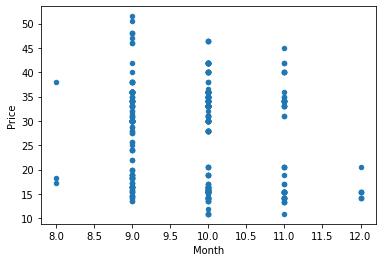

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

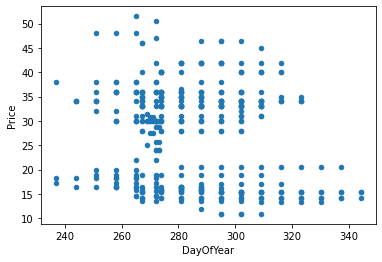

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Mukhang maliit ang ugnayan, ngunit may iba pang mas mahalagang relasyon - dahil ang mga presyo sa plot sa itaas ay tila may ilang magkakaibang kumpol. Gumawa tayo ng plot na magpapakita ng iba't ibang uri ng kalabasa:


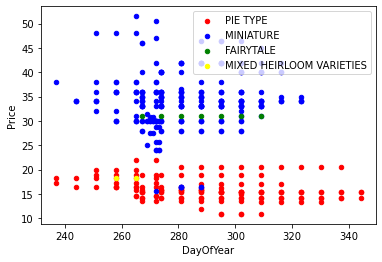

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

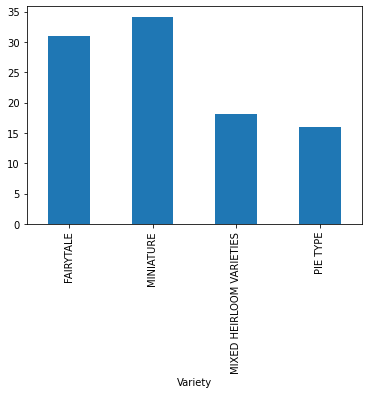

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

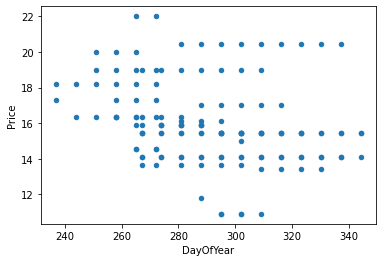

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Linear Regression

Gagamitin natin ang Scikit Learn upang magsanay ng linear regression model:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


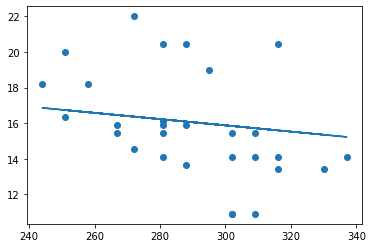

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Ang slope ng linya ay maaaring matukoy mula sa mga coefficient ng linear regression:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polynomial Regression

Minsan, ang relasyon sa pagitan ng mga tampok at resulta ay likas na hindi linear. Halimbawa, maaaring mataas ang presyo ng kalabasa tuwing taglamig (mga buwan=1,2), pagkatapos ay bumaba sa tag-init (mga buwan=5-7), at pagkatapos ay tumaas muli. Hindi kayang mahanap ng linear regression ang relasyong ito nang tama.

Sa ganitong kaso, maaari nating isaalang-alang ang pagdaragdag ng mga karagdagang tampok. Isang simpleng paraan ay ang paggamit ng mga polynomial mula sa mga input na tampok, na magreresulta sa **polynomial regression**. Sa Scikit Learn, maaari nating awtomatikong i-pre-compute ang mga polynomial na tampok gamit ang pipelines:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


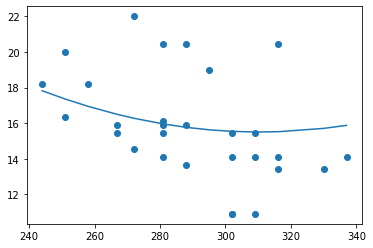

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Pag-encode ng mga uri

Sa ideal na mundo, nais nating magawang hulaan ang mga presyo para sa iba't ibang uri ng kalabasa gamit ang parehong modelo. Upang maisaalang-alang ang uri, kailangan muna nating i-convert ito sa numerikong anyo, o **i-encode**. Mayroong ilang mga paraan upang gawin ito:

* Simpleng numerikong encoding na gagawa ng isang talahanayan ng iba't ibang uri, at pagkatapos ay papalitan ang pangalan ng uri ng isang index sa talahanayan na iyon. Hindi ito ang pinakamainam na ideya para sa linear regression, dahil isinasaalang-alang ng linear regression ang numerikong halaga ng index, at ang numerikong halaga ay malamang na hindi tumutugma nang numerikal sa presyo.
* One-hot encoding, na papalitan ang kolum na `Variety` ng 4 na magkakaibang kolum, isa para sa bawat uri, na maglalaman ng 1 kung ang kaukulang hilera ay kabilang sa ibinigay na uri, at 0 kung hindi.

Ang code sa ibaba ay nagpapakita kung paano natin maaaring i-one-hot encode ang isang uri:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Linear Regression sa Iba't Ibang Uri

Gagamitin natin ngayon ang parehong code tulad ng nasa itaas, ngunit sa halip na `DayOfYear`, gagamitin natin ang ating one-hot-encoded na uri bilang input:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Maaari rin nating subukang gumamit ng iba pang mga tampok sa parehong paraan, at pagsamahin ang mga ito sa mga numerikal na tampok, tulad ng `Month` o `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polynomial Regression

Ang polynomial regression ay maaari ring gamitin sa mga kategoryang tampok na naka-one-hot-encode. Ang code para sa pagsasanay ng polynomial regression ay halos pareho sa nakita natin sa itaas.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Paunawa**:  
Ang dokumentong ito ay isinalin gamit ang AI translation service na [Co-op Translator](https://github.com/Azure/co-op-translator). Bagama't sinisikap naming maging tumpak, pakitandaan na ang mga awtomatikong pagsasalin ay maaaring maglaman ng mga pagkakamali o hindi pagkakatugma. Ang orihinal na dokumento sa orihinal nitong wika ang dapat ituring na opisyal na sanggunian. Para sa mahalagang impormasyon, inirerekomenda ang propesyonal na pagsasalin ng tao. Hindi kami mananagot sa anumang hindi pagkakaunawaan o maling interpretasyon na maaaring magmula sa paggamit ng pagsasaling ito.
